# **Intro VAE**
In this notebook I use a variational autoencoder (VAE) in order to determine the single-cell perturbation effect.



The experimental set-up is as follows:
All data is from Kang dataset.
We generate pesudobulks from the original data, which contains 8 samples and 1 stimulated and one ctrl condition per sample.
We either perturb all cells, a single cell-type, or no cell types. 
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `exp_id`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang"
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the "labeled" data (meaning each sample has a ground truth cell-type proportion and it is from the cell-type proportion) and 6 samples with unlabeled data (ground truth proportions are not used in training.)




A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb


# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import scanpy as sc

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from comparator_models import vae
from comparator_models.models import vae4
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [66]:
## parameters
aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../../results/single_cell_data/VAE_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_kang/CIBERSORTx_Job22_Results.csv"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_kang/"

# bp results
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

exp_id = "mono-kang"

RETRAIN_MODELS = False

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8


# number of patients/domains/samples expected
n_tot_samples = 8 # 8 bulk and single cell samples

# number of drugs one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


# Define indices and set-up metadata

In [5]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6928)[-6928:]
gene_df = gene_df.iloc[idx_top]


# compare our variable genes with cibersort defined genes

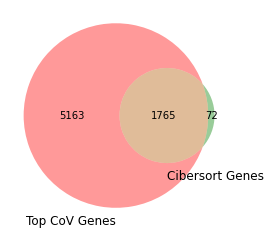

In [6]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [7]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

# Normalize data

In [8]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


X_vae = X_full[idx_train,]
label_vae = label_full[idx_train,]
bulk_vae = bulk_full[idx_train,]
drug_vae = drug_full[idx_train,]
y_vae = Y_full.iloc[idx_train,]




# Plot all data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.067s...
[t-SNE] Computed neighbors for 17320 samples in 24.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for sa

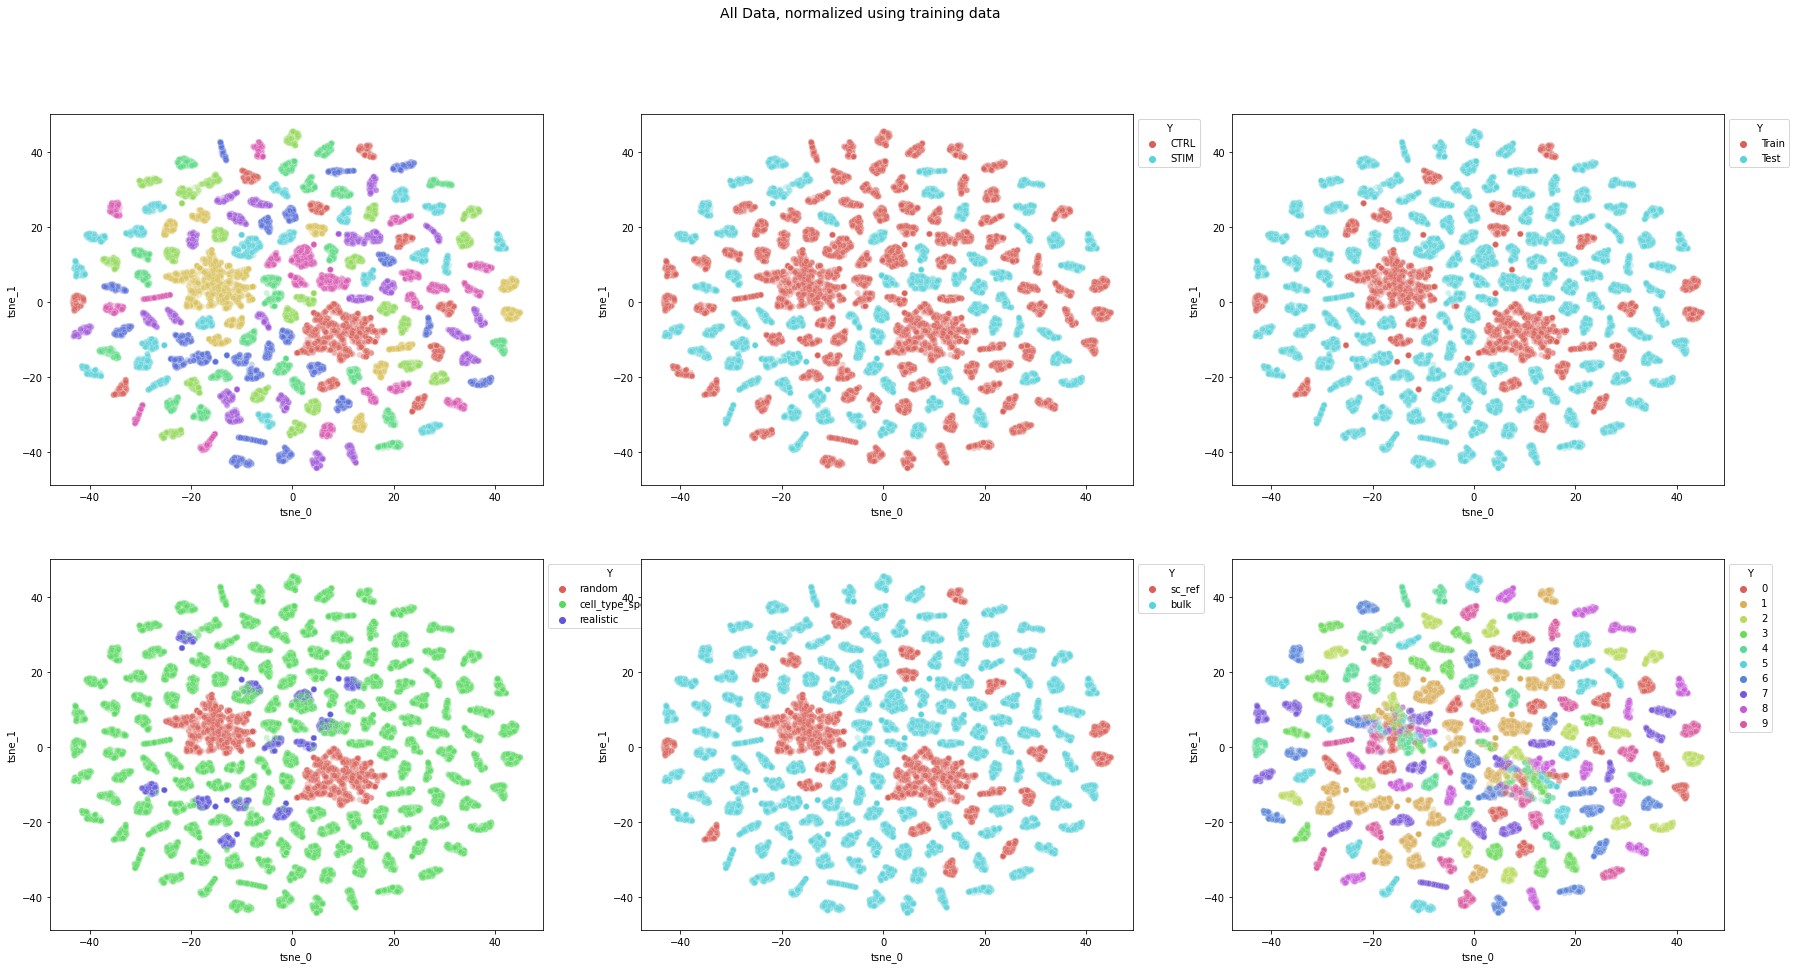

In [9]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run VAE**

## Hyperparameter Search

We are going to search over 2 parameters: 

1.  the beta_kl (0.001, 0.01, 1, 10)
2.  the number of epochs  (50, 100)

In [157]:
from importlib import reload  # Python 3.4+
reload(vae)
reload(vae4)
reload(sc_preprocess)
reload(vp)


<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../buddi/plotting/validation_plotting.py'>

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


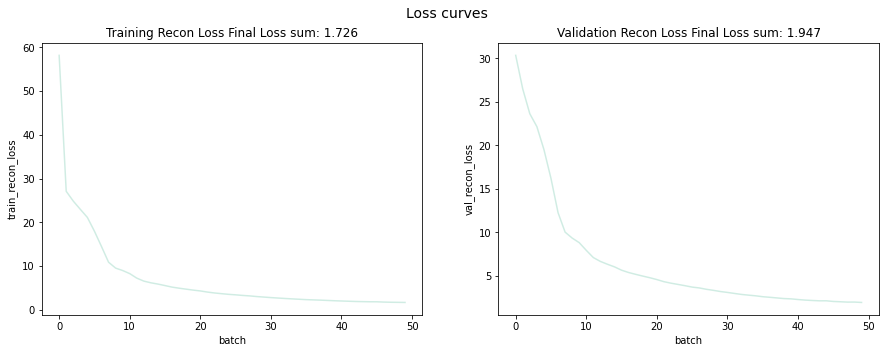

In [11]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 10
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


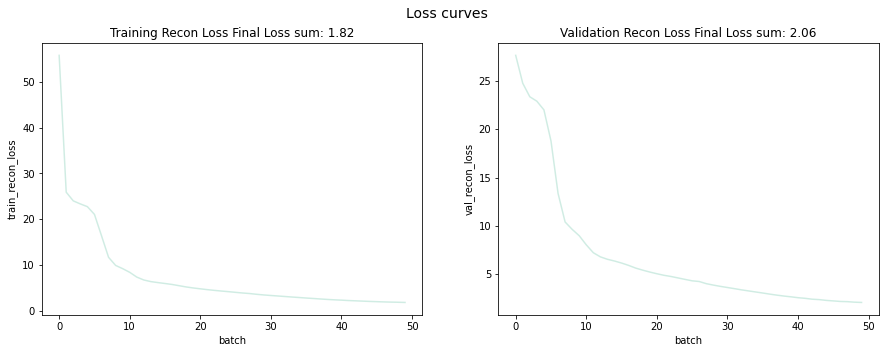

In [12]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 50
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


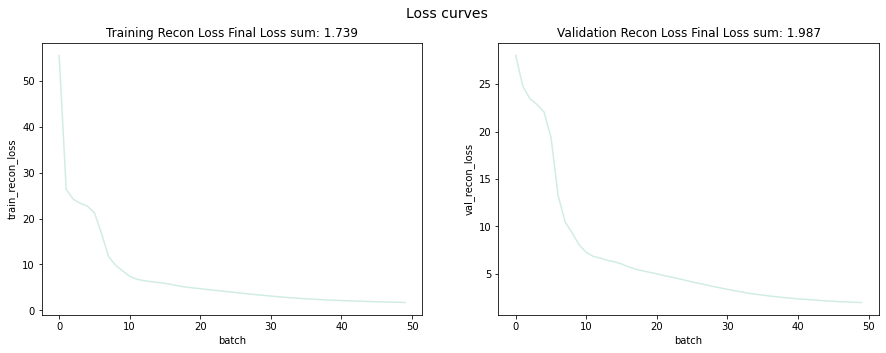

In [13]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 100
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


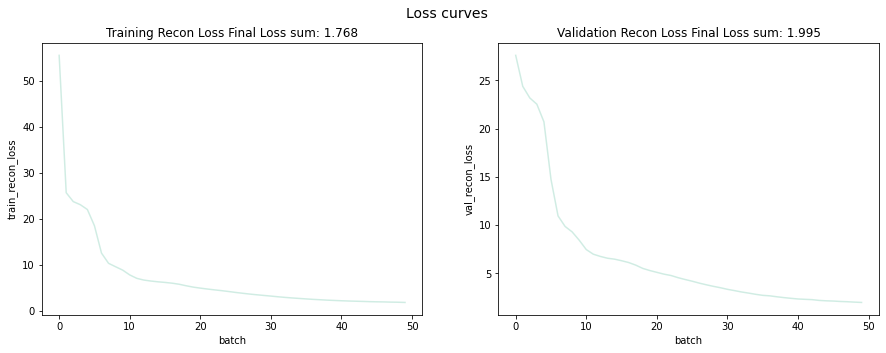

In [14]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 200
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.001_mono-kang_decoder/assets


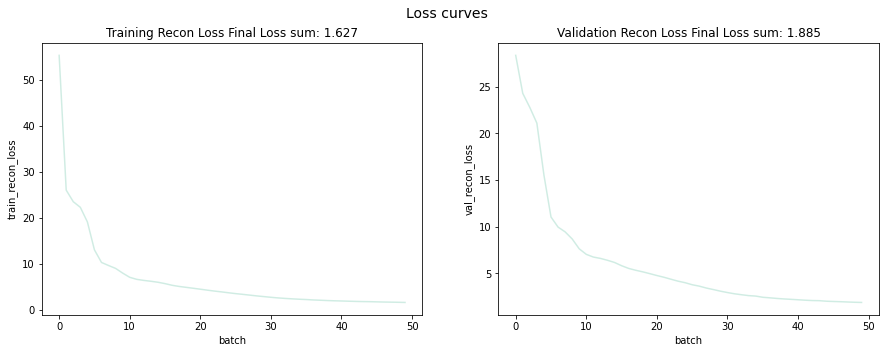

In [15]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 300
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


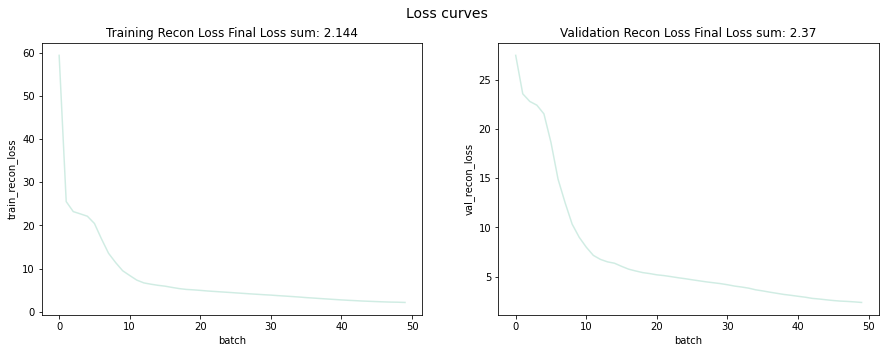

In [16]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 10
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


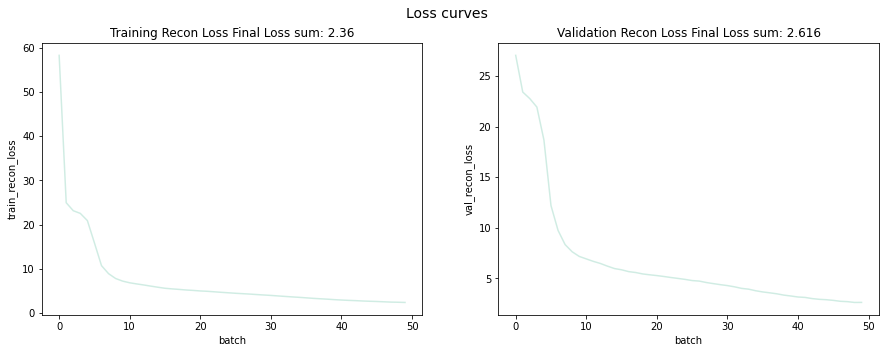

In [17]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 50
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


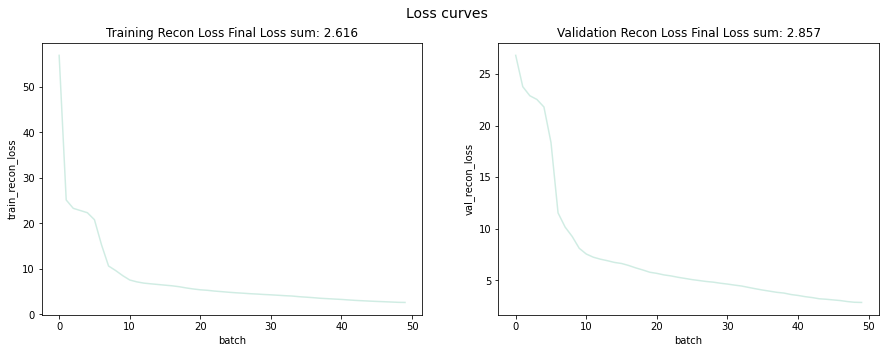

In [18]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 100
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


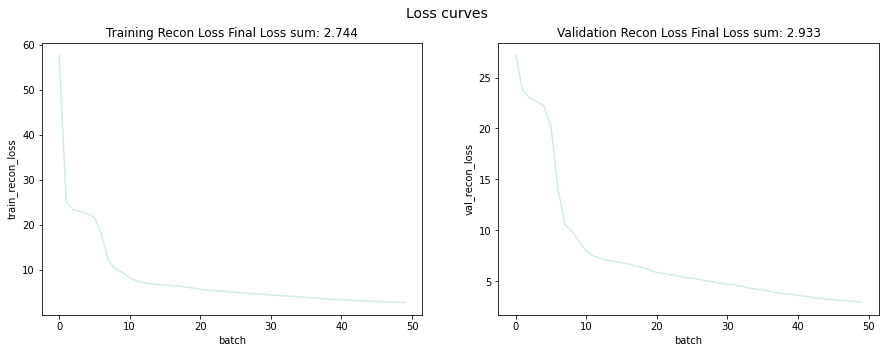

In [19]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 200
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_0.01_mono-kang_decoder/assets


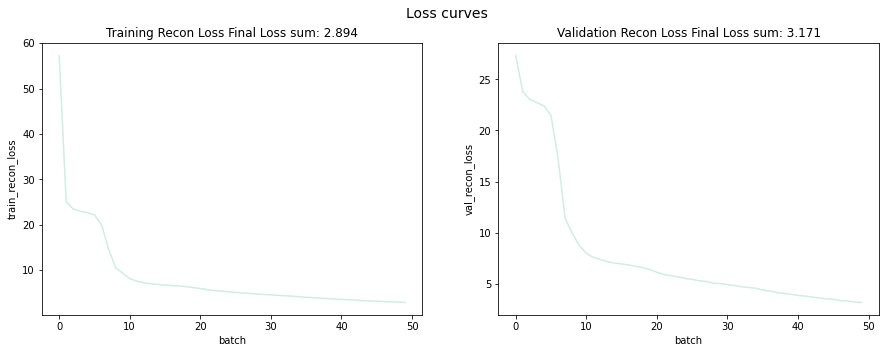

In [20]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 300
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


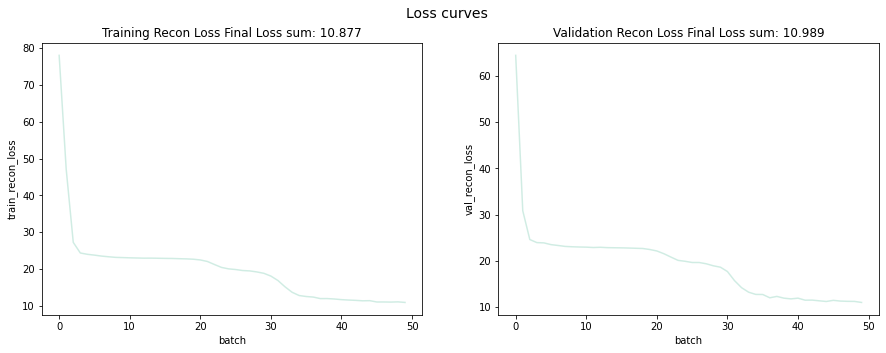

In [21]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 10
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


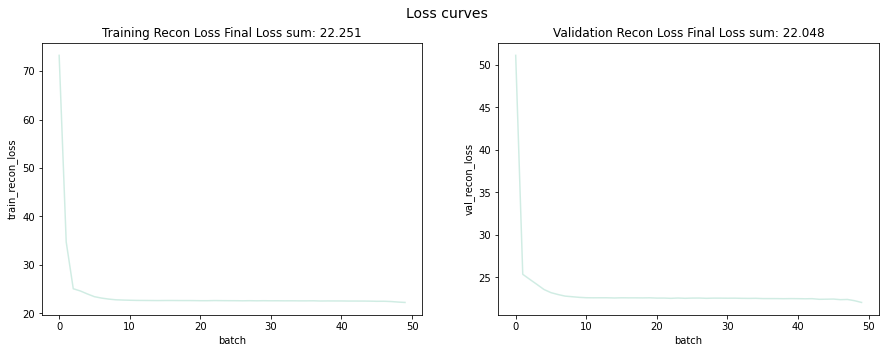

In [22]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 50
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


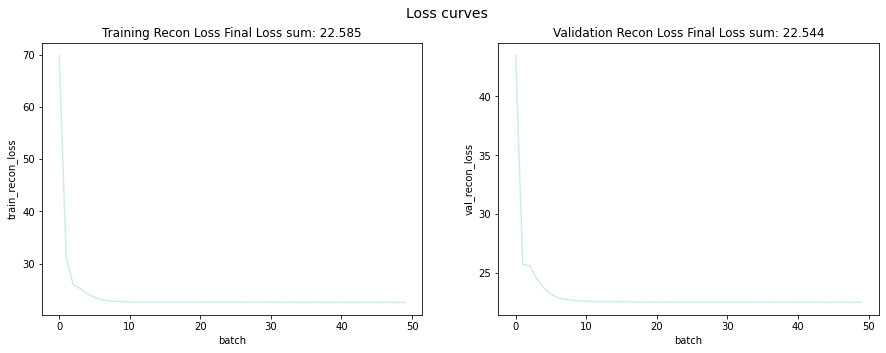

In [23]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 100
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


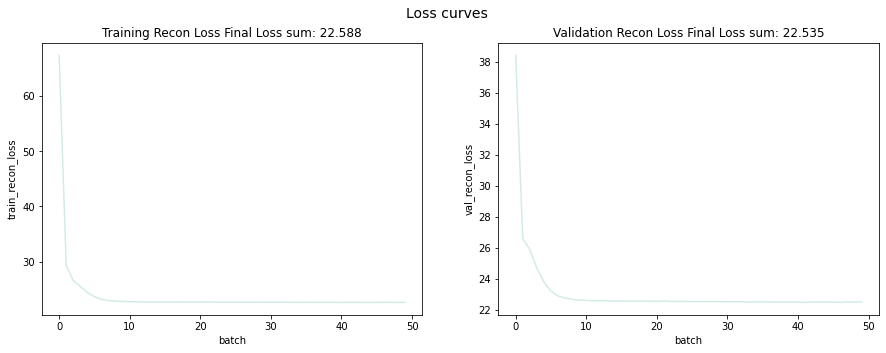

In [24]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 200
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_1_mono-kang_decoder/assets


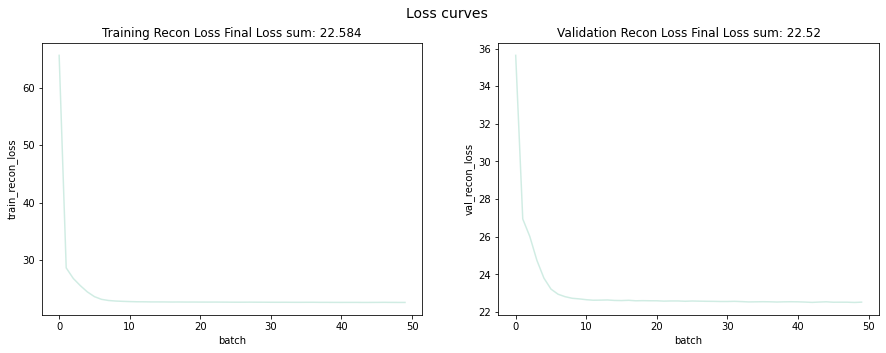

In [25]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 300
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


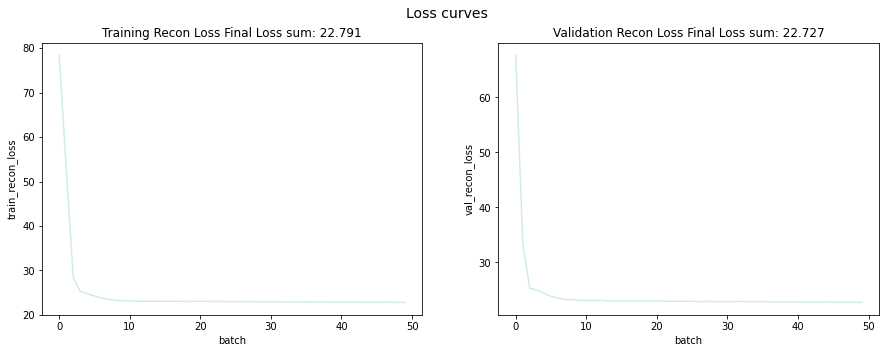

In [26]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 10
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


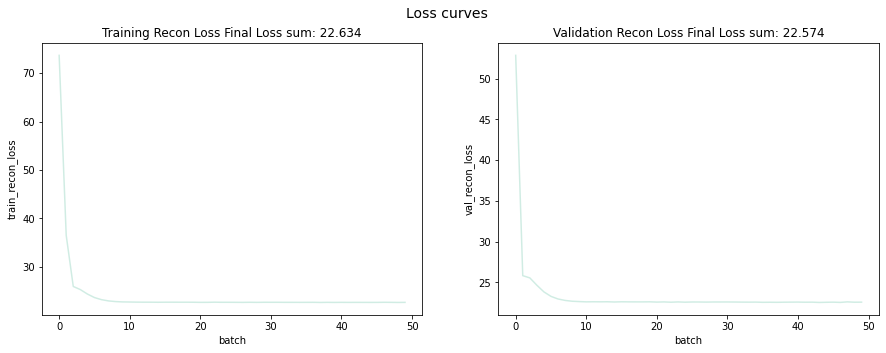

In [27]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 50
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


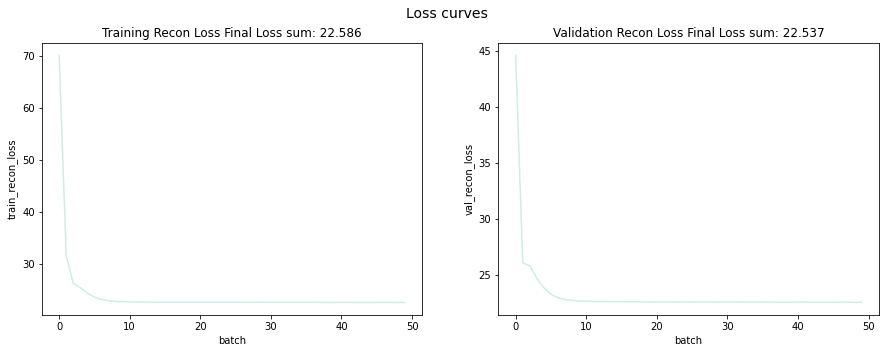

In [28]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 100
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


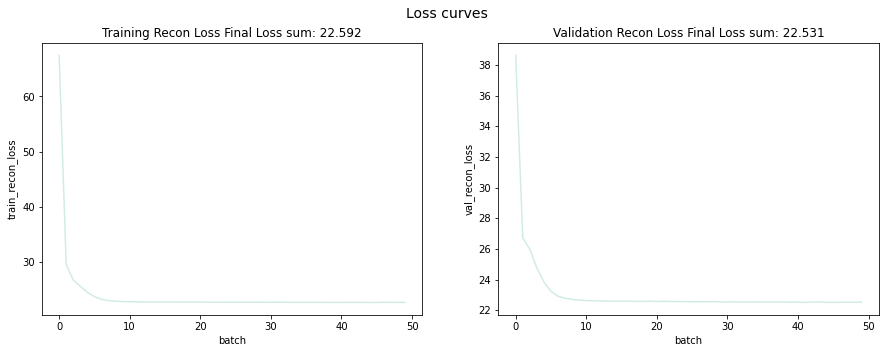

In [29]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 200
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/buddiM2_kang//50_10_mono-kang_decoder/assets


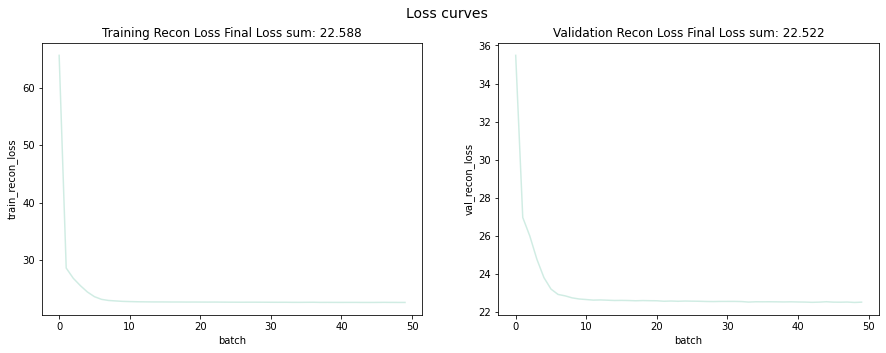

In [30]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 300
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

# **Results**

Looking at all the results, we see that beta_kl = 0.001 performs the best overall. We will go forward with this hyperparameters and run them three times to get 3 different trained models that we can use for downstream validation.

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model1_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model1_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model1_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model1_mono-kang_decoder/assets
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model2_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model2_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model2_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model2_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model2_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model2_mono-kang_decoder/assets
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model3_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model3_mono-kang_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model3_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model3_mono-kang_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model3_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../results/single_cell_data/VAE_kang//model3_mono-kang_decoder/assets


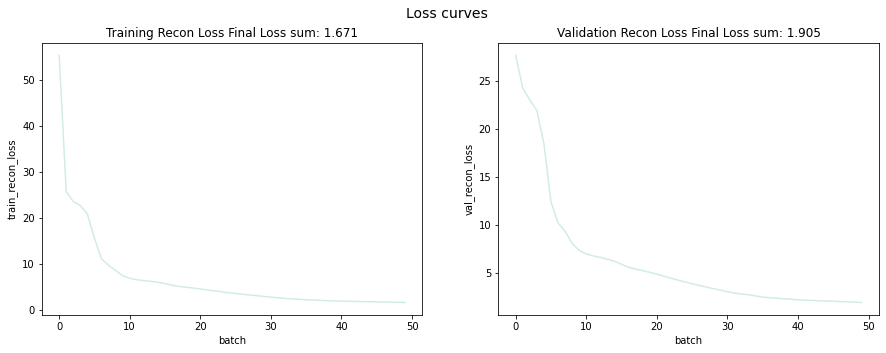

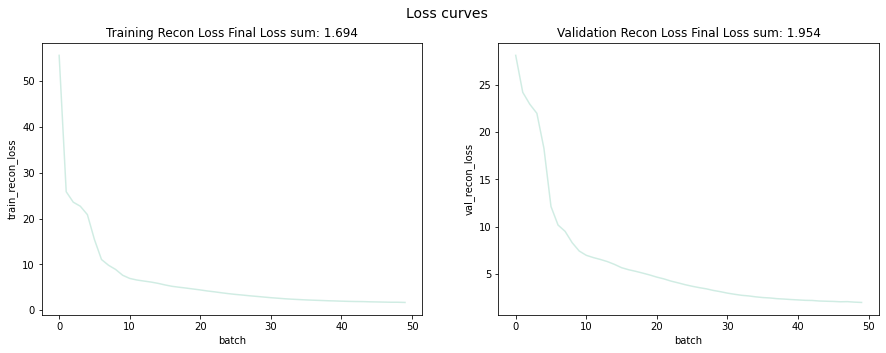

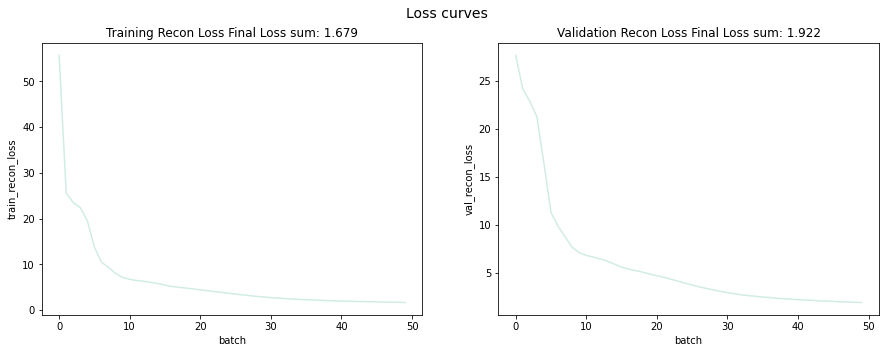

In [306]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 1000

params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl)

## model 1
curr_exp_id = f"model1_{exp_id}"
res1 = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)


## model 2
curr_exp_id = f"model2_{exp_id}"
res2 = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

## model 3
curr_exp_id = f"model3_{exp_id}"
res3 = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)            

# visualize reconstructions

### subset data

In [297]:
# take all training data
recon_idx = meta_df.isTraining == "Train"
recon_idx = np.where(recon_idx)[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)

# subset our data

meta_temp = meta_df.iloc[recon_idx]

X_temp = np.copy(X_full[recon_idx])

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)


label_temp = np.copy(label_full[recon_idx])
label_num = np.copy(Label_full[recon_idx])

perturb_temp = drug_full[recon_idx]

bulk_temp = bulk_full[recon_idx]




### plot data

(10000, 2)
(10000, 2)


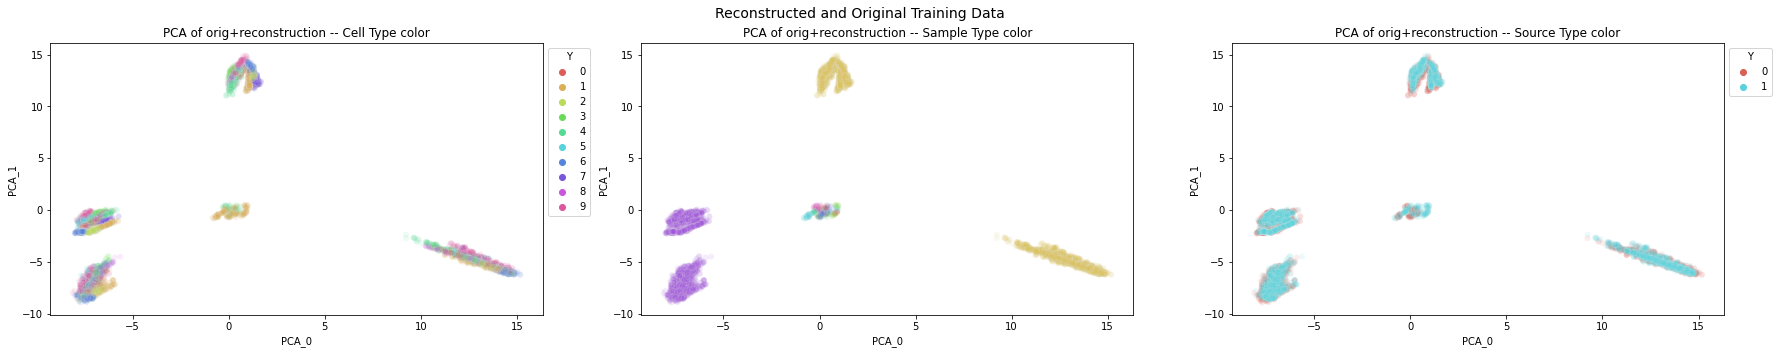

In [310]:
res1_recon_plot = vae.plot_reconstruction_vae(res1.encoder, res1.decoder,
        X_temp, Y_temp, label_num,
        batch_size=500)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


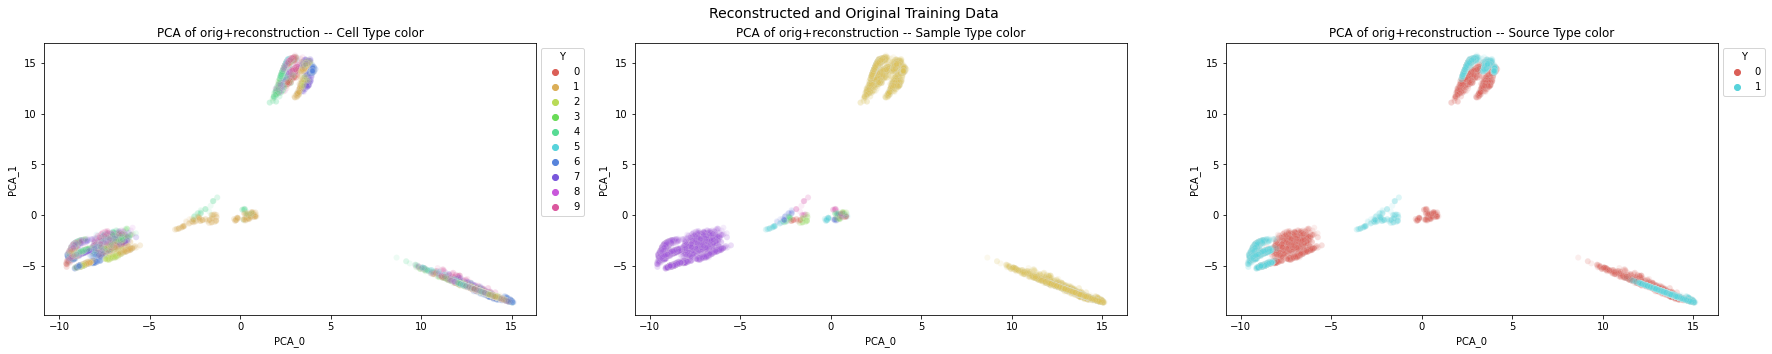

In [71]:
res2_recon_plot = vae.plot_reconstruction_vae(res2.encoder, res2.decoder,
        X_temp, Y_temp, label_num,
        batch_size=500)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


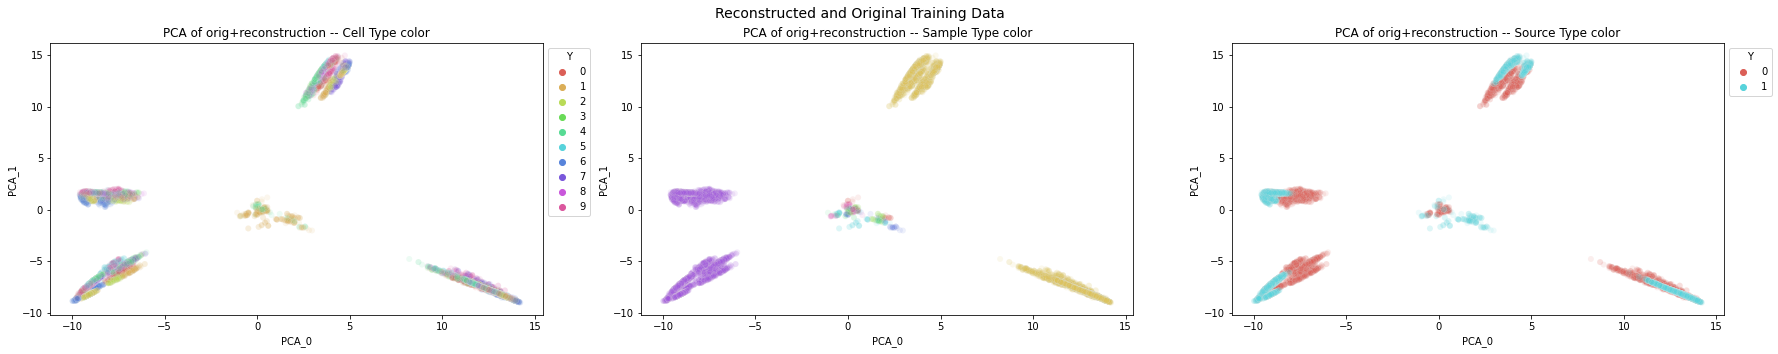

In [72]:
res3_recon_plot = vae.plot_reconstruction_vae(res3.encoder, res3.decoder,
        X_temp, Y_temp, label_num,
        batch_size=500)

# Do latent space projections

### drug perturbation

In [280]:
from importlib import reload  # Python 3.4+
reload(vae)
reload(vae4)
reload(sc_preprocess)
reload(vp)


<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../buddi/plotting/validation_plotting.py'>

In [281]:
res1_meta_df, res1_decoded_0_0, res1_decoded_0_1 = vp.calc_VAE_perturbation_new(X_full, meta_df, 
                                                                        res1.encoder, res1.decoder, 
                                                                        scaler, batch_size=500)

res1_decoded_0_1 = np.clip(res1_decoded_0_1, 0, clip_upper)
res1_decoded_0_0 = np.clip(res1_decoded_0_0, 0, clip_upper)


In [282]:
res1_meta_df

,sample_id,stim,isTraining,cell_prop_type,samp_type,Y_max
1000,1488,CTRL,Test,cell_type_specific,sc_ref,CD14_Mono
1001,1488,CTRL,Test,cell_type_specific,sc_ref,CD14_Mono
1002,1488,CTRL,Test,cell_type_specific,sc_ref,CD14_Mono
1003,1488,CTRL,Test,cell_type_specific,sc_ref,CD14_Mono
1004,1488,CTRL,Test,cell_type_specific,sc_ref,CD14_Mono
...,...,...,...,...,...,...
1995,107,CTRL,Test,cell_type_specific,sc_ref,NK
1996,107,CTRL,Test,cell_type_specific,sc_ref,NK
1997,107,CTRL,Test,cell_type_specific,sc_ref,NK
1998,107,CTRL,Test,cell_type_specific,sc_ref,NK


In [307]:
res1_meta_df, res1_decoded_0_0, res1_decoded_0_1 = vp.calc_VAE_perturbation_new(X_full, meta_df, 
                                                                        res1.encoder, res1.decoder, 
                                                                        scaler, batch_size=500)

res2_meta_df, res2_decoded_0_0, res2_decoded_0_1 = vp.calc_VAE_perturbation_new(X_full, meta_df, 
                                                                        res2.encoder, res2.decoder, 
                                                                        scaler, batch_size=500)

res3_meta_df, res3_decoded_0_0, res3_decoded_0_1 = vp.calc_VAE_perturbation_new(X_full, meta_df, 
                                                                        res3.encoder, res3.decoder, 
                                                                        scaler, batch_size=500)


res1_decoded_0_1 = np.clip(res1_decoded_0_1, 0, clip_upper)
res1_decoded_0_0 = np.clip(res1_decoded_0_0, 0, clip_upper)

res2_decoded_0_1 = np.clip(res2_decoded_0_1, 0, clip_upper)
res2_decoded_0_0 = np.clip(res2_decoded_0_0, 0, clip_upper)

res3_decoded_0_1 = np.clip(res3_decoded_0_1, 0, clip_upper)
res3_decoded_0_0 = np.clip(res3_decoded_0_0, 0, clip_upper)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/kera

In [293]:

# run first the cell_type specific things

def get_prediction_res(X_full, Y_full, res1_decoded_0_0, 
                        res1_decoded_0_1, scaler, 
                        meta_df, res1_meta_df):

    cell_type_specific_r2 = None
    cell_type_specific_real = None
    cell_type_specific_proj = None
    meta_DESeq = None
    all_samps = ['101', '1016', '1039', '107', '1244', '1488']
    all_samps = ['101', '1016']



    for curr_samp in all_samps:
        print(curr_samp)
        for curr_cell_type in Y_full.columns:
            print(curr_cell_type)

            real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, res1_decoded_0_0, 
                                                                                            res1_decoded_0_1, scaler, curr_samp, 
                                                                                            "cell_type_specific", 
                                                                                            meta_df, res1_meta_df,
                                                                                            curr_cell_type)

            expr_r2_stim, expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse, expr_stim_rmse, expr_ctrl_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

            curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2_stim,
                        expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, 
                        log2FC_r2_top, log2FC_rmse, expr_stim_rmse, expr_ctrl_rmse]
            curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 
                                                            'expr_r2_stim', 'expr_r2_ctrl', 'log2FC_r2',
                                                            'log2FC_r2_bottom', 'log2FC_r2_mid', 'log2FC_r2_top', 'log2FC_rmse',
                                                            'expr_stim_rmse', 'expr_ctrl_rmse'])

            curr_meta_real = {'sample_id':[curr_samp]*(real_ctrl.shape[0]+ real_stim.shape[0]),
                            'cell_type':[curr_cell_type]*(real_ctrl.shape[0]+ real_stim.shape[0]),
                            'cond':['ctrl']*(real_ctrl.shape[0]) + ['stim']*(real_stim.shape[0])}
            curr_meta_real = pd.DataFrame(curr_meta_real)

            curr_meta_proj = {'sample_id':[curr_samp]*(proj_ctrl.shape[0]+ proj_stim.shape[0]),
                            'cell_type':[curr_cell_type]*(proj_ctrl.shape[0]+ proj_stim.shape[0]),
                            'cond':['ctrl']*(proj_ctrl.shape[0]) + ['stim']*(proj_stim.shape[0])}
            curr_meta_proj = pd.DataFrame(curr_meta_proj)
            
            curr_DESeq_real = np.append(real_ctrl, real_stim, axis=0)
            curr_DESeq_proj = np.append(proj_ctrl, proj_stim, axis=0)

            if cell_type_specific_r2 is None:
                cell_type_specific_r2 = curr_res
                meta_DESeq_real = curr_meta_real
                meta_DESeq_proj = curr_meta_proj
                cell_type_specific_real = curr_DESeq_real
                cell_type_specific_proj = curr_DESeq_proj
            else:
                cell_type_specific_r2 = pd.concat([cell_type_specific_r2, curr_res])
                meta_DESeq_real = pd.concat([meta_DESeq_real, curr_meta_real])
                meta_DESeq_proj = pd.concat([meta_DESeq_proj, curr_meta_proj])
                cell_type_specific_real = np.append(cell_type_specific_real, curr_DESeq_real, axis=0)
                cell_type_specific_proj = np.append(cell_type_specific_proj, curr_DESeq_proj, axis=0)

    return cell_type_specific_r2, meta_DESeq_real, meta_DESeq_proj, cell_type_specific_real, cell_type_specific_proj

# now run the realistic ones

In [302]:

real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, res1_decoded_0_0, 
                                                                                res1_decoded_0_1, scaler, "101", 
                                                                                "cell_type_specific", 
                                                                                meta_df, res1_meta_df,
                                                                                "CD14_Mono")


In [303]:
expr_r2_stim, expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse, expr_stim_rmse, expr_ctrl_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)


In [304]:
expr_r2_stim

0.6127103355455344

In [305]:
log2FC_r2

0.09202071839002657

In [288]:

real_ctrl = np.median(real_ctrl, axis=0)+1
real_stim = np.median(real_stim, axis=0)+1
real_log2FC = np.log2(real_stim/real_ctrl)

proj_ctrl = np.median(proj_ctrl, axis=0)+1
proj_stim = np.median(proj_stim, axis=0)+1
proj_log2FC = np.log2(proj_stim/proj_ctrl)


log2FC_r2 = spearmanr(real_log2FC, proj_log2FC)[0]


In [250]:
proj_stim

array([   7.8119783,   35.127235 ,    3.9216359, ..., 1761.6204   ,
        342.93927  ,  174.93835  ], dtype=float32)

In [251]:
proj_ctrl

array([  12.811132,  167.46432 ,    9.436138, ..., 1902.8157  ,
        125.451866,   73.11769 ], dtype=float32)

In [252]:
real_stim

array([  1. ,   1. ,   1. , ..., 271.5,   1. ,  48. ])

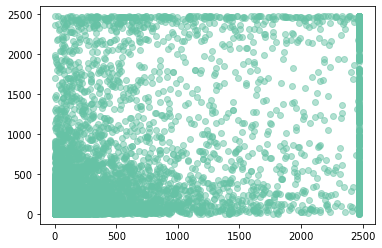

In [290]:

plt.scatter(real_ctrl, proj_ctrl, alpha=0.5)
plt.show()

In [308]:

res1_r2, _, _, _, _  = get_prediction_res(X_full, Y_full, res1_decoded_0_0, 
                        res1_decoded_0_1, scaler, 
                        meta_df, res1_meta_df)

101
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1016
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act


In [309]:
res1_r2

,sample_id,cell_type,bulk_type,expr_r2_stim,expr_r2_ctrl,log2FC_r2,log2FC_r2_bottom,log2FC_r2_mid,log2FC_r2_top,log2FC_rmse,expr_stim_rmse,expr_ctrl_rmse
0,101,B,cell_type_specific,0.610111,0.615209,0.045606,0.071462,0.056720,0.108430,1.796689,781.099131,767.905037
0,101,CD14_Mono,cell_type_specific,0.599472,0.599824,0.081893,0.075376,0.186555,0.127528,2.743015,794.625966,767.834565
0,101,CD16_Mono,cell_type_specific,0.631789,0.616889,0.041217,0.041719,0.133475,0.183385,1.860286,792.180965,786.440584
0,101,CD4_Mem_T,cell_type_specific,0.627471,0.623971,0.046011,0.018356,0.089968,0.112431,1.806334,715.588725,708.272086
0,101,CD4_Naive_T,cell_type_specific,0.598978,0.597409,0.054609,0.039626,0.131615,0.100370,1.794392,772.552015,769.031711
0,101,CD8_T,cell_type_specific,0.595578,0.596442,0.038262,0.038735,0.091699,0.063488,1.794148,778.500389,772.644736
0,101,DC,cell_type_specific,0.596353,0.593691,0.038370,0.033173,0.071362,0.045500,1.702876,904.327252,906.570934
0,101,Mk,cell_type_specific,0.598166,0.586915,0.037986,0.040884,0.041031,0.042576,1.814580,879.717271,902.422072
0,101,NK,cell_type_specific,0.587894,0.583405,0.046029,0.017396,0.148267,0.085008,1.831690,788.787869,782.454730
0,101,T_Act,cell_type_specific,0.614604,0.617170,0.053385,0.055127,0.036914,0.063268,1.724741,826.079309,832.013143


In [80]:

res1_r2, _, _, _, _  = get_prediction_res(X_full, Y_full, res1_decoded_0_0, 
                        res1_decoded_0_1, scaler, 
                        meta_df, res1_meta_df)

res2_r2, _, _, _, _ = get_prediction_res(X_full, Y_full, res2_decoded_0_0, 
                        res2_decoded_0_1, scaler, 
                        meta_df, res2_meta_df)

res3_r2, _, _, _, _ = get_prediction_res(X_full, Y_full, res3_decoded_0_0, 
                        res3_decoded_0_1, scaler, 
                        meta_df, res3_meta_df)



101
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1016
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1039
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


107
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1244
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1488
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


101
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1016
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1039
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


107
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1244
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1488
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


101
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1016
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1039
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


107
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1244
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1488
B


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD14_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD16_Mono


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Mem_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD4_Naive_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


CD8_T


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


DC


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Mk


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NK


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


T_Act


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [81]:
res_r2 = pd.concat([res1_r2, res2_r2, res3_r2])
res_r2

,sample_id,cell_type,bulk_type,expr_r2_stim,expr_r2_ctrl,log2FC_r2,log2FC_r2_bottom,log2FC_r2_mid,log2FC_r2_top,log2FC_rmse,expr_stim_rmse,expr_ctrl_rmse
0,101,B,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,CD14_Mono,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,CD16_Mono,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,CD4_Mem_T,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,CD4_Naive_T,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
0,1488,CD8_T,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1488,DC,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1488,Mk,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1488,NK,cell_type_specific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_VAE.csv")
res_r2.to_csv(pearson_res_file, index=False)
